In [5]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, locally_linear_embedding

### Ascertain that the untrained model weights are random

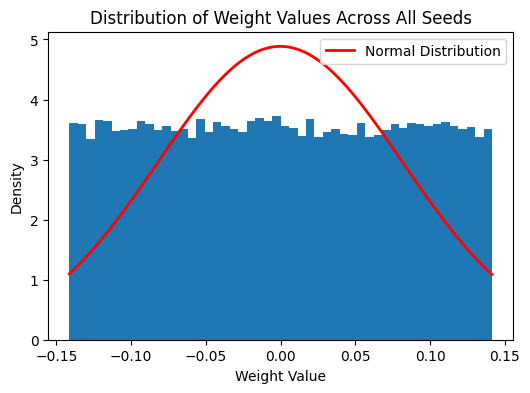

Mean of weights: -0.0002
Std of weights: 0.0817
Min of weights: -0.1414
Max of weights: 0.1414


In [11]:
model_type = 'fully_connected'
dataset_type = 'mnist'
untrained = True
untrained_string = '-untrained' if untrained else ''

# Collect weights from all seeds and analyze their distribution
all_weights = []
for seed in range(100):
    model = torch.load(f'saved_models/{model_type}-{dataset_type}{untrained_string}/seed-{seed}')
    weights = model['layers.2.weight'].cpu().detach()
    all_weights.append(weights.numpy().flatten())

# Convert to numpy array for easier analysis
all_weights = np.array(all_weights)

# Create histogram of weights across all seeds
plt.figure(figsize=(6, 4))
plt.hist(all_weights.flatten(), bins=50, density=True)
plt.title('Distribution of Weight Values Across All Seeds')
plt.xlabel('Weight Value')
plt.ylabel('Density')

# Add a reference normal distribution
from scipy.stats import norm
x = np.linspace(all_weights.min(), all_weights.max(), 100)
plt.plot(x, norm.pdf(x, all_weights.mean(), all_weights.std()), 
         'r-', lw=2, label='Normal Distribution')
plt.legend()
plt.show()

# Print some statistics
print(f"Mean of weights: {all_weights.mean():.4f}")
print(f"Std of weights: {all_weights.std():.4f}")
print(f"Min of weights: {all_weights.min():.4f}")
print(f"Max of weights: {all_weights.max():.4f}")

### Readout weights - relational analysis

torch.Size([10, 50])


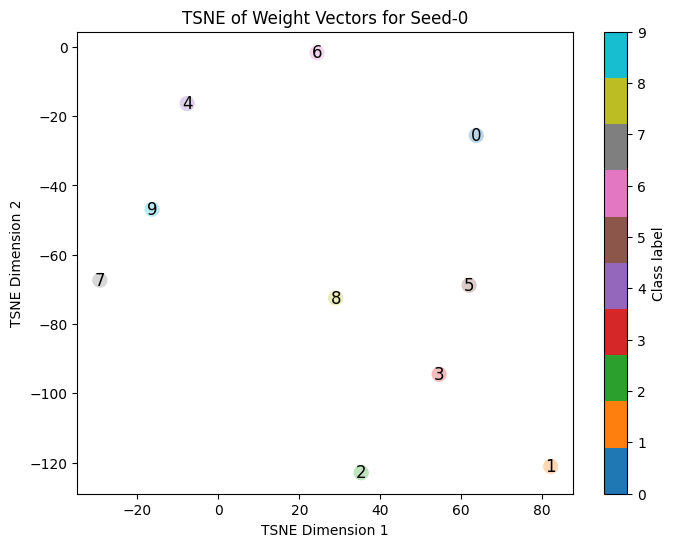

In [ ]:
model_type = 'fully_connected_dropout'
dataset_type = 'mnist'
weight_matrices = []
untrained = False
untrained_string = 'untrained' if untrained else ''
n_seeds_to_plot = 1
for seed in range(n_seeds_to_plot):
    model = torch.load(f'saved_models/{model_type}-{dataset_type}{untrained_string}/seed-{seed}')
    weights = model['layers.2.weight'].cpu().detach()

    print(weights.shape)
    # reduce dimensionality of weights
    # You can switch between PCA and TSNE; here we use TSNE as in your code.
    weights_reduced = TSNE(n_components=2, learning_rate='auto',
                           init='random', perplexity=3).fit_transform(weights)

    num_displayed_dots = 10  # assuming we have exactly 10 classes
    classes = list(range(num_displayed_dots))  # class labels 0 to 9

    plt.figure(figsize=(8, 6))
    # Use a discrete colormap (tab10) so that each class gets a unique color.
    scatter = plt.scatter(weights_reduced[:num_displayed_dots, 0],
                          weights_reduced[:num_displayed_dots, 1],
                          c=classes, cmap='tab10', s=100)
    
    # Add a colorbar with class ticks (optional)
    cbar = plt.colorbar(scatter, ticks=classes)
    cbar.set_label('Class label')

    # Annotate each point with its class label.
    for i, cls in enumerate(classes):
        plt.text(weights_reduced[i, 0],
                 weights_reduced[i, 1],
                 str(cls),
                 fontsize=12,
                 ha='center',
                 va='center',
                 color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    plt.title(f'TSNE of Weight Vectors for Seed-{seed}')
    plt.xlabel('TSNE Dimension 1')
    plt.ylabel('TSNE Dimension 2')
    plt.show()